In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from pymongo import MongoClient
from Tbrain_service import DataPreproecss
from Tbrain_service import DataVisualization
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from keras.layers import LSTM, Dense, TimeDistributed
from keras.models import Sequential

/home/mark/anaconda3/envs/tensorflow/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/mark/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(center=False,window=12).mean()
    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    # Perform Augmented Dickey-Fuller test:
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [4]:
def etf_data_preprocess(df):
    df['代碼'] = df['代碼'].str.strip()
    df['中文簡稱'] = df['中文簡稱'].str.strip()
    df['日期'] = pd.to_datetime(df['日期'])
    for col in df.columns[3:]:
        df[col] = df[col].map(lambda x: float("".join("".join(x.split()).split(','))))
    return df

In [5]:
def decide_up_and_down(x):
    if x > 0:
        result = 1
    elif x < 0:
        result = -1
    else:
        result = 0
    return result

In [6]:
def perform_linear_regression(etf_df):
    # test data
    test_X = etf_df.iloc[-5:]
    train_df = dp.trans_time_series_to_supervised(etf_df, 5, '收盤價(元)')
    
    # train_df = etf_df.iloc[:-5,]
    # test_df = etf_df.iloc[-5:,]
    train_X = train_df.loc[:,train_df.columns!='y']
    train_y = train_df.loc[:,train_df.columns=='y']

    # test_X = test_df.loc[:,train_df.columns!='y']
    # test_y = test_df.loc[:,train_df.columns=='y']

    model = LinearRegression()
    model.fit(train_X, train_y)
    pred = model.predict(test_X).flatten()
    return pred

In [7]:
def perform_ARIMA(etf_df):
    train_series = etf_df.loc[:,['收盤價(元)']]
    # arima p, d, and q parameters
    model = ARIMA(train_series, order=(5,0,0))  
    model = model.fit()
    start_index = len(train_series) - 1
    end_index = len(train_series) - 1 + 4
    pred = model.predict(start_index, end_index, dynamic= True)
    return pred

In [48]:
def define_RNN_model():
    time_step = 5
    model = Sequential()
    model.add(LSTM(20, input_shape=(time_step, 1), return_sequences=True))
    model.add(LSTM(20, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss="mse", optimizer="adam")
    return model

In [70]:
def perform_RNN(etf_df):
    dp = DataPreproecss()
    time_step = 5
    etf_df = etf_df.loc[:,['收盤價(元)']]
    etf_df_window = dp.make_slide_windows(etf_df, time_step * 2)
    train_X = etf_df_window.iloc[:,:time_step]
    train_X_scale, scaler_X = dp.standardize(train_X)
    train_y = etf_df_window.iloc[:,-time_step:]
    train_y_scale, scaler_y = dp.standardize(train_y)
    # 最先一週
    test_X_scale = scaler_X.transform(etf_df_window.iloc[-1:,-time_step:])
    # reshape
    train_X_scale = train_X_scale.reshape(len(train_X_scale), time_step, 1)
    train_y_scale = train_y_scale.reshape(len(train_X_scale), time_step, 1)
    test_X_scale = test_X_scale.reshape(len(test_X_scale), time_step, 1)
    print("train_X_scale: {}, train_y_scale: {}, test_X_scale: {}".format(train_X_scale.shape, train_y_scale.shape, test_X_scale.shape))
    # train model
    model = define_RNN_model()
    model.fit(train_X_scale, train_y_scale, epochs=50, batch_size=32, verbose=1, validation_split=0.2)
    
    # predict
    pred = model.predict(test_X_scale)
    pred = pred.reshape(1, 5)
    pred = scaler_y.inverse_transform(pred).flatten()
    return pred
    

In [9]:
csv_list = os.listdir('TBrain_Round2_DataSet_20180511')

In [10]:
csv_list

['tasharep.csv', 'tetfp.csv', 'taetfp.csv', 'tsharep.csv']

In [9]:
# write CSV to mongoDB
# mongo = MongoBase('mongodb://220.133.208.31:27017/', 'test-database')
# for csv_name in csv_list:
#     df = pd.read_csv('csv/' + csv_name, encoding='cp950', dtype='str')
#     collection_name = csv_name.split('.')[0]
#     mongo.insert_document(collection_name, etf_data_preprocess(df))

In [11]:
# tetfp: 18 檔 ETF
# taetfp: 調整後 18 檔 ETF 
# tsharep: 個股
# tasharep: 調整後個股

df = pd.read_csv('TBrain_Round2_DataSet_20180511/taetfp.csv', encoding='cp950', dtype='str')
df = etf_data_preprocess(df)

etf_code_list = list(df.groupby(df['代碼']).size().index)

In [12]:
# 資料分布屬性
df.groupby(df['代碼']).size()

代碼
0050      1312
0051      1312
0052      1312
0053      1312
0054      1312
0055      1312
0056      1312
0057      1312
0058      1312
0059      1312
006201    1312
006203    1312
006204    1312
006208    1312
00690      274
00692      244
00701      179
00713      150
dtype: int64

In [13]:
etf_df = df.loc[df['代碼']==etf_code_list[0],]
etf_df = etf_df.loc[:,['收盤價(元)']].set_index(etf_df['日期'])

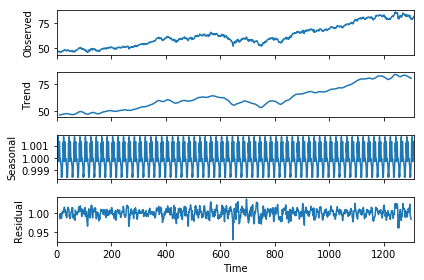

In [24]:
# Decompose time series
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(etf_df['收盤價(元)'].values, 'multiplicative', freq=20)
result.plot()
plt.show()

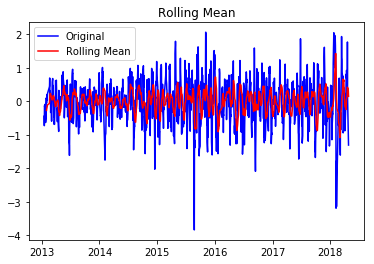

Results of Augmented Dickey-Fuller test:
Test Statistic                -1.143014e+01
p-value                        6.547103e-21
#Lags Used                     2.100000e+01
Number of Observations Used    1.270000e+03
Critical Value (1%)           -3.435510e+00
Critical Value (5%)           -2.863818e+00
Critical Value (10%)          -2.567983e+00
dtype: float64


In [124]:
residual = pd.Series(result.resid, index=etf_df.index)
residual.dropna(inplace=True)
test_stationarity(residual)

In [71]:
# collect predict result
submission_list = []
for etf_code in etf_code_list:
    etf_df = df.loc[df['代碼']==etf_code,:]
    # set to time index
    etf_df = etf_df.loc[:,['成交張數(張)', '收盤價(元)']].set_index(etf_df['日期'])
    # linear regression
    # pred = perform_linear_regression(etf_df)
    # ARIMA
    # pred =perform_ARIMA(etf_df)
    # RNN
    pred = perform_RNN(etf_df)
    # 預測前上一個紀錄的值
    pev_price = etf_df.iloc[-1:, etf_df.columns == '收盤價(元)'].values.flatten()
    r1 = np.round(np.concatenate([pev_price, pred])[:5],2)
    r2 = np.round(pred, 2)
    
    # make up submission csv
    up_list = list(map(decide_up_and_down, r2 - r1))
    cprice_list = r2.tolist()
    
    submission_records = []
    for i in range(1,11):
        if i % 2 == 1:
            submission_records.append(up_list.pop(0))
        else:
            submission_records.append(cprice_list.pop(0))
    submission_list.append([int(etf_code)] + submission_records)

train_X_scale: (1303, 5, 1), train_y_scale: (1303, 5, 1), test_X_scale: (1, 5, 1)
Train on 1042 samples, validate on 261 samples
Epoch 1/50
1042/1042 [==============================] - 1s - loss: 0.4220 - val_loss: 2.3917
Epoch 2/50
1042/1042 [==============================] - 0s - loss: 0.2269 - val_loss: 1.8609
Epoch 3/50
1042/1042 [==============================] - 0s - loss: 0.1680 - val_loss: 1.3358
Epoch 4/50
1042/1042 [==============================] - 0s - loss: 0.1258 - val_loss: 0.9923
Epoch 5/50
1042/1042 [==============================] - 0s - loss: 0.0913 - val_loss: 0.8961
Epoch 6/50
1042/1042 [==============================] - 0s - loss: 0.0675 - val_loss: 0.8275
Epoch 7/50
1042/1042 [==============================] - 0s - loss: 0.0545 - val_loss: 0.7638
Epoch 8/50
1042/1042 [==============================] - 0s - loss: 0.0435 - val_loss: 0.6700
Epoch 9/50
1042/1042 [==============================] - 0s - loss: 0.0336 - val_loss: 0.5936
Epoch 10/50
1042/1042 [===========

1042/1042 [==============================] - 0s - loss: 0.0296 - val_loss: 0.3249
Epoch 36/50
1042/1042 [==============================] - 0s - loss: 0.0294 - val_loss: 0.3401
Epoch 37/50
1042/1042 [==============================] - 0s - loss: 0.0295 - val_loss: 0.3257
Epoch 38/50
1042/1042 [==============================] - 0s - loss: 0.0297 - val_loss: 0.3223
Epoch 39/50
1042/1042 [==============================] - 0s - loss: 0.0299 - val_loss: 0.3233
Epoch 40/50
1042/1042 [==============================] - 0s - loss: 0.0299 - val_loss: 0.3207
Epoch 41/50
1042/1042 [==============================] - 0s - loss: 0.0299 - val_loss: 0.3128
Epoch 42/50
1042/1042 [==============================] - 0s - loss: 0.0296 - val_loss: 0.3197
Epoch 43/50
1042/1042 [==============================] - 0s - loss: 0.0293 - val_loss: 0.3150
Epoch 44/50
1042/1042 [==============================] - 0s - loss: 0.0294 - val_loss: 0.3145
Epoch 45/50
1042/1042 [==============================] - 0s - loss: 0.02

1042/1042 [==============================] - 0s - loss: 0.0107 - val_loss: 0.2768
Epoch 20/50
1042/1042 [==============================] - 0s - loss: 0.0105 - val_loss: 0.2570
Epoch 21/50
1042/1042 [==============================] - 0s - loss: 0.0104 - val_loss: 0.2472
Epoch 22/50
1042/1042 [==============================] - 0s - loss: 0.0102 - val_loss: 0.2355
Epoch 23/50
1042/1042 [==============================] - 0s - loss: 0.0101 - val_loss: 0.2263
Epoch 24/50
1042/1042 [==============================] - 0s - loss: 0.0100 - val_loss: 0.2162
Epoch 25/50
1042/1042 [==============================] - 0s - loss: 0.0098 - val_loss: 0.2064
Epoch 26/50
1042/1042 [==============================] - 0s - loss: 0.0098 - val_loss: 0.1908
Epoch 27/50
1042/1042 [==============================] - 0s - loss: 0.0097 - val_loss: 0.1864
Epoch 28/50
1042/1042 [==============================] - 0s - loss: 0.0096 - val_loss: 0.1704
Epoch 29/50
1042/1042 [==============================] - 0s - loss: 0.00

1042/1042 [==============================] - 0s - loss: 0.1808 - val_loss: 0.9774
Epoch 4/50
1042/1042 [==============================] - 0s - loss: 0.1432 - val_loss: 0.8310
Epoch 5/50
1042/1042 [==============================] - 0s - loss: 0.1106 - val_loss: 0.7720
Epoch 6/50
1042/1042 [==============================] - 0s - loss: 0.0829 - val_loss: 0.6979
Epoch 7/50
1042/1042 [==============================] - 0s - loss: 0.0666 - val_loss: 0.6314
Epoch 8/50
1042/1042 [==============================] - 0s - loss: 0.0543 - val_loss: 0.5447
Epoch 9/50
1042/1042 [==============================] - 0s - loss: 0.0442 - val_loss: 0.4654
Epoch 10/50
1042/1042 [==============================] - 0s - loss: 0.0368 - val_loss: 0.4057
Epoch 11/50
1042/1042 [==============================] - 0s - loss: 0.0326 - val_loss: 0.3577
Epoch 12/50
1042/1042 [==============================] - 0s - loss: 0.0302 - val_loss: 0.3223
Epoch 13/50
1042/1042 [==============================] - 0s - loss: 0.0290 - v

1042/1042 [==============================] - 1s - loss: 0.5752 - val_loss: 2.2810
Epoch 2/50
1042/1042 [==============================] - 0s - loss: 0.3350 - val_loss: 1.7581
Epoch 3/50
1042/1042 [==============================] - 0s - loss: 0.2298 - val_loss: 1.2118
Epoch 4/50
1042/1042 [==============================] - 0s - loss: 0.1822 - val_loss: 0.9322
Epoch 5/50
1042/1042 [==============================] - 0s - loss: 0.1502 - val_loss: 0.8588
Epoch 6/50
1042/1042 [==============================] - 0s - loss: 0.1194 - val_loss: 0.7966
Epoch 7/50
1042/1042 [==============================] - 0s - loss: 0.0929 - val_loss: 0.7160
Epoch 8/50
1042/1042 [==============================] - 0s - loss: 0.0771 - val_loss: 0.6451
Epoch 9/50
1042/1042 [==============================] - 0s - loss: 0.0646 - val_loss: 0.5523
Epoch 10/50
1042/1042 [==============================] - 0s - loss: 0.0538 - val_loss: 0.4735
Epoch 11/50
1042/1042 [==============================] - 0s - loss: 0.0452 - val

1042/1042 [==============================] - 0s - loss: 0.0353 - val_loss: 0.2322
Epoch 38/50
1042/1042 [==============================] - 0s - loss: 0.0353 - val_loss: 0.2467
Epoch 39/50
1042/1042 [==============================] - 0s - loss: 0.0353 - val_loss: 0.2397
Epoch 40/50
1042/1042 [==============================] - 0s - loss: 0.0353 - val_loss: 0.2485
Epoch 41/50
1042/1042 [==============================] - 0s - loss: 0.0353 - val_loss: 0.2378
Epoch 42/50
1042/1042 [==============================] - 0s - loss: 0.0354 - val_loss: 0.2387
Epoch 43/50
1042/1042 [==============================] - 0s - loss: 0.0353 - val_loss: 0.2461
Epoch 44/50
1042/1042 [==============================] - 0s - loss: 0.0354 - val_loss: 0.2356
Epoch 45/50
1042/1042 [==============================] - 0s - loss: 0.0352 - val_loss: 0.2427
Epoch 46/50
1042/1042 [==============================] - 0s - loss: 0.0356 - val_loss: 0.2342
Epoch 47/50
1042/1042 [==============================] - 0s - loss: 0.03

1042/1042 [==============================] - 0s - loss: 0.0161 - val_loss: 0.3166
Epoch 22/50
1042/1042 [==============================] - 0s - loss: 0.0159 - val_loss: 0.3067
Epoch 23/50
1042/1042 [==============================] - 0s - loss: 0.0158 - val_loss: 0.2795
Epoch 24/50
1042/1042 [==============================] - 0s - loss: 0.0157 - val_loss: 0.2703
Epoch 25/50
1042/1042 [==============================] - 0s - loss: 0.0156 - val_loss: 0.2495
Epoch 26/50
1042/1042 [==============================] - 0s - loss: 0.0156 - val_loss: 0.2359
Epoch 27/50
1042/1042 [==============================] - 0s - loss: 0.0153 - val_loss: 0.2304
Epoch 28/50
1042/1042 [==============================] - 0s - loss: 0.0153 - val_loss: 0.2155
Epoch 29/50
1042/1042 [==============================] - 0s - loss: 0.0151 - val_loss: 0.1974
Epoch 30/50
1042/1042 [==============================] - 0s - loss: 0.0151 - val_loss: 0.1867
Epoch 31/50
1042/1042 [==============================] - 0s - loss: 0.01

212/212 [==============================] - 0s - loss: 0.5800 - val_loss: 1.2339
Epoch 6/50
212/212 [==============================] - 0s - loss: 0.5095 - val_loss: 1.1639
Epoch 7/50
212/212 [==============================] - 0s - loss: 0.4468 - val_loss: 1.0644
Epoch 8/50
212/212 [==============================] - 0s - loss: 0.4114 - val_loss: 0.9619
Epoch 9/50
212/212 [==============================] - 0s - loss: 0.3889 - val_loss: 0.8564
Epoch 10/50
212/212 [==============================] - 0s - loss: 0.3636 - val_loss: 0.7624
Epoch 11/50
212/212 [==============================] - 0s - loss: 0.3428 - val_loss: 0.6793
Epoch 12/50
212/212 [==============================] - 0s - loss: 0.3263 - val_loss: 0.6102
Epoch 13/50
212/212 [==============================] - 0s - loss: 0.3118 - val_loss: 0.5582
Epoch 14/50
212/212 [==============================] - 0s - loss: 0.2991 - val_loss: 0.5173
Epoch 15/50
212/212 [==============================] - 0s - loss: 0.2896 - val_loss: 0.4889
Epoc

188/188 [==============================] - 0s - loss: 0.2144 - val_loss: 0.2603
Epoch 43/50
188/188 [==============================] - 0s - loss: 0.2113 - val_loss: 0.2538
Epoch 44/50
188/188 [==============================] - 0s - loss: 0.2083 - val_loss: 0.2477
Epoch 45/50
188/188 [==============================] - 0s - loss: 0.2052 - val_loss: 0.2423
Epoch 46/50
188/188 [==============================] - 0s - loss: 0.2021 - val_loss: 0.2380
Epoch 47/50
188/188 [==============================] - 0s - loss: 0.1995 - val_loss: 0.2328
Epoch 48/50
188/188 [==============================] - 0s - loss: 0.1968 - val_loss: 0.2283
Epoch 49/50
188/188 [==============================] - 0s - loss: 0.1944 - val_loss: 0.2231
Epoch 50/50
188/188 [==============================] - 0s - loss: 0.1918 - val_loss: 0.2192
train_X_scale: (170, 5, 1), train_y_scale: (170, 5, 1), test_X_scale: (1, 5, 1)
Train on 136 samples, validate on 34 samples
Epoch 1/50
136/136 [==============================] - 1s - 

112/112 [==============================] - 0s - loss: 1.0082 - val_loss: 0.5252
Epoch 29/50
112/112 [==============================] - 0s - loss: 1.0054 - val_loss: 0.5244
Epoch 30/50
112/112 [==============================] - 0s - loss: 1.0027 - val_loss: 0.5235
Epoch 31/50
112/112 [==============================] - 0s - loss: 0.9995 - val_loss: 0.5228
Epoch 32/50
112/112 [==============================] - 0s - loss: 0.9976 - val_loss: 0.5224
Epoch 33/50
112/112 [==============================] - 0s - loss: 0.9947 - val_loss: 0.5215
Epoch 34/50
112/112 [==============================] - 0s - loss: 0.9906 - val_loss: 0.5201
Epoch 35/50
112/112 [==============================] - 0s - loss: 0.9870 - val_loss: 0.5182
Epoch 36/50
112/112 [==============================] - 0s - loss: 0.9845 - val_loss: 0.5162
Epoch 37/50
112/112 [==============================] - 0s - loss: 0.9802 - val_loss: 0.5138
Epoch 38/50
112/112 [==============================] - 0s - loss: 0.9771 - val_loss: 0.5115


In [72]:
submission_df = pd.DataFrame(data=submission_list, columns=[
    'ETFid','Mon_ud', 'Mon_cprice', 'Tue_ud', 'Tue_cprice', 'Wed_ud', 'Wed_cprice',
    'Thu_ud', 'Thu_cprice', 'Fri_ud', 'Fri_cprice'
])

In [73]:
submission_df

,ETFid,Mon_ud,Mon_cprice,Tue_ud,Tue_cprice,Wed_ud,Wed_cprice,Thu_ud,Thu_cprice,Fri_ud,Fri_cprice
0,50,-1,75.389999,1,78.099998,1,79.190002,1,79.690002,1,80.739998
1,51,-1,29.230000,1,30.240000,1,30.400000,1,30.469999,1,30.559999
2,52,-1,45.980000,1,47.919998,1,48.459999,1,48.980000,1,49.459999
3,53,-1,32.500000,1,33.980000,1,34.459999,1,34.689999,1,35.160000
4,54,-1,22.459999,1,23.010000,1,23.129999,1,23.250000,1,23.389999
5,55,-1,15.670000,1,16.219999,1,16.230000,1,16.240000,1,16.350000
6,56,-1,24.600000,1,25.110001,-1,25.059999,1,25.070000,1,25.120001
7,57,-1,46.040001,1,47.750000,1,48.360001,1,48.820000,1,49.340000
8,58,-1,43.599998,1,45.189999,1,45.709999,1,46.139999,1,46.860001
9,59,-1,38.509998,1,39.500000,1,39.889999,1,39.959999,1,40.270000


In [206]:
submission_df.to_csv('result.csv', index=False)